In [24]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("../Functions")
from GS_waves import from_files
from skimage.transform import rotate
import hyperspy.api as hs
import atomap.api as am
from sklearn import mixture
from lmfit import Model
from tqdm import tqdm
import circle_fit as cf
from abtem.core.energy import energy2wavelength
from scipy.stats import linregress
import scipy
from Column_matching import (
    match_parameters_Bessel,
    propagation_Bessel,
    inv_Bessel,
    Bessel_transform
    )
from Complex_Gaussian import (
    Gaussian_function,
    Gaussian_in_focus,
    Gaussian_fitting
)
from Defocus_circle import generate_continious_phase
from scipy.optimize import minimize
def select_column(ew, peak_sites, distance, index):
    n_col, n_row = peak_sites[index,:]
    dist = int(distance)
    lx, ux = n_col - dist, n_col + dist
    ly, uy = n_row - dist, n_row + dist
    ew_sel = ew[ly:uy, lx:ux]
    return ew_sel

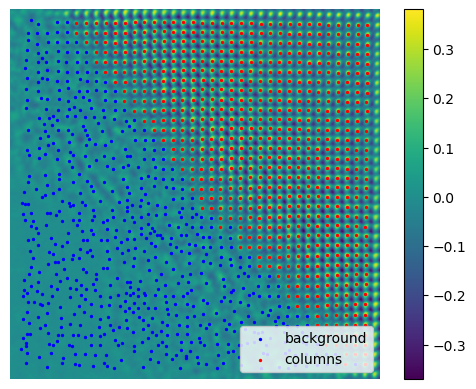

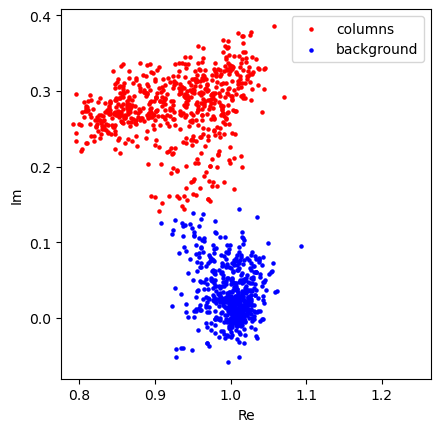

In [9]:
#Import image
ew_all = from_files("Dataset60_export_000_ExitWave.tif",
                    "../data/Ag@Al_3")
#Rotate image
angle = -11.538931172768631
ew_all = rotate(np.real(ew_all), angle) + 1j*rotate(np.imag(ew_all), angle)
#Select image to analyze
rl, ru, cl, cu, cut = 1892, 3108, 734, 1950, 30
ew_sel = ew_all[rl:ru, cl:cu]
ew_bound = ew_all[rl+cut:ru-cut, cl+cut:cu-cut]
#Find peaks
signal = hs.signals.Signal2D(np.angle(ew_bound))
peak = am.get_atom_positions(signal, pca=True, separation=5) + cut
#Classify peaks
values = np.array([ew_sel[int(peak[index, 1]), int(peak[index, 0])] for index in range(peak.shape[0])])
threshold = 0.15
#index_sel = np.abs(values-1) > threshold
index_sel = np.logical_and(np.angle(values) > threshold, np.abs(values-1) > threshold)
#Identify lattice
sublattice = am.Sublattice(peak[index_sel],
                        image=np.abs(ew_bound),
                        fix_negative_values=True)
sublattice.construct_zone_axes()
lattice = np.array(sublattice.zones_axis_average_distances)
Argand_points = np.vstack((np.real(values), np.imag(values))).T
#Plot 1: mapping phase and peaks
plt.scatter(peak[~index_sel,0], peak[~index_sel,1],s=2, color='b', label='background')
plt.scatter(peak[index_sel,0], peak[index_sel,1],s=2, color='r', label='columns')
plt.legend()
plt.imshow(np.angle(ew_sel))
plt.colorbar()
plt.axis("off")
plt.show()
#Plot 2: Argand plots of peaks
plt.scatter(np.real(values[index_sel]), np.imag(values[index_sel]), color='r', s=5, label="columns")
plt.scatter(np.real(values[~index_sel]), np.imag(values[~index_sel]), color='b', s=5, label="background")
plt.legend()
plt.xlabel("Re")
plt.ylabel("Im")
plt.axis("square")
plt.show()

In [30]:
energy = 300e3; sampling = 0.05656015
gmin=0.01; gmax=1.5; length=50
#Shift peak positions for better convergence
#shift_factor = np.array([0.5, 0.5])/sampling
peak_sites = peak[index_sel,:]
#peak_sites = peak_sites + np.array([int(shift_factor[0]), int(shift_factor[1])])
distance = np.linalg.norm(lattice[1,:])
a = sampling * distance
#Conduct MLE optimization on columns using Levenberg–Marquardt algorithm
error_rec = []
coeffs_rec = []
peak_rec = []
cutoff = 2
cut_factor = 0.01
krange = np.linspace(gmin+cut_factor, gmax, length)
fitting_range = [0.25, 1]
for i in tqdm(range(peak_sites.shape[0])):
    ew_col = select_column(ew_sel, peak_sites, distance/2, i)
    coeffs = match_parameters_Bessel(ew_col, sampling, gmin, gmax, method="BFGS")
    coeffs_rec.append(coeffs)
    coeffs = match_parameters_Bessel(ew_col, sampling, 0.01, 1, method="BFGS")
    rx, ry, bg_amp, bg_pha = coeffs
    bg = bg_amp * np.exp(1j*bg_pha)
    results, components = Bessel_transform(ew_col-bg, sampling, gmin, gmax, 50, rx, ry)
    fitted = Gaussian_fitting(results, krange, fitting_range)
    coeff = np.array(list(fitted.best_values.values()))
    recover = Gaussian_function(krange, *coeff)
    peak_rec.append(coeff[0]+coeff[-2]+1j*(coeff[1]+coeff[-1]))
peak_rec = np.array(peak_rec)

100%|██████████| 633/633 [11:13<00:00,  1.06s/it]


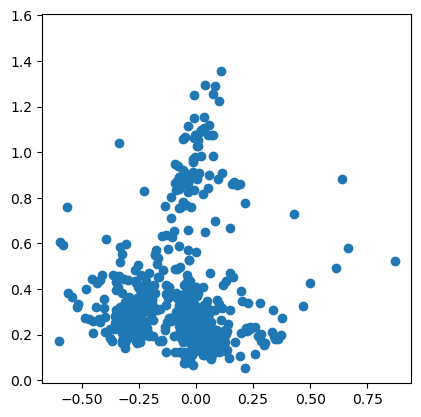

In [32]:
plt.scatter(np.real(peak_rec), np.imag(peak_rec))
plt.axis("square")
plt.show()

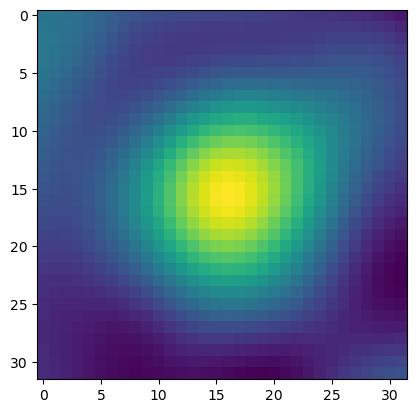

In [21]:
plt.imshow(np.angle(ew_col))
plt.show()

In [14]:
print(res.x)

[ 1.          1.27745601 -4.60914339 -1.09213512]


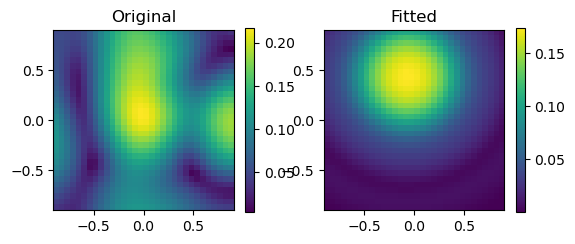

In [22]:
a = sampling * ew_col.shape[0]
gmin = 0.01; gmax = 1.5
coeffs = match_parameters_Bessel(ew_col, sampling, 0.01, 1, method="BFGS")
rx, ry, bg_amp, bg_pha = coeffs
bg = bg_amp * np.exp(1j*bg_pha)
results, components = Bessel_transform(ew_col-bg, sampling, gmin, gmax, 50, rx, ry)
plt.subplot(1, 2, 1)
plt.imshow(np.abs(ew_col-bg), extent=[-a/2, a/2, -a/2, a/2])
plt.colorbar(shrink=0.5)
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(np.abs(components), extent=[-a/2, a/2, -a/2, a/2])
plt.colorbar(shrink=0.5)
plt.title("Fitted")
plt.show()

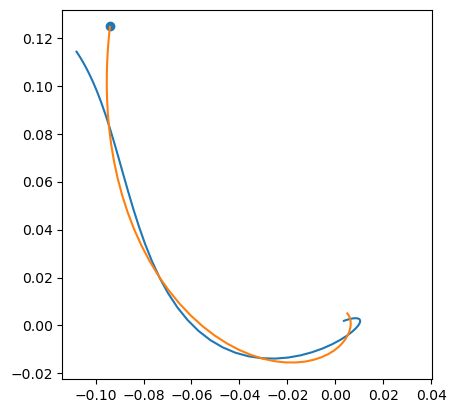

In [34]:
cut_factor = 0.01
krange = np.linspace(gmin+cut_factor, gmax, length)
fitted = Gaussian_fitting(results, krange, [0.25, 1])
coeff = np.array(list(fitted.best_values.values()))
recover = Gaussian_function(krange, *coeff)
plt.plot(np.real(results), np.imag(results))
plt.plot(np.real(recover), np.imag(recover))
plt.scatter(coeff[0]+coeff[-2],coeff[1]+coeff[-1])
plt.axis("square")
plt.show()